[Kaggle Code Link](https://www.kaggle.com/code/kunalaldar/diabetes-prediction-smote/notebook)  Type-2 Diabetes

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
df = pd.read_csv('/content/diabetes_prediction_dataset.csv')

In [ ]:
df['diabetes'].value_counts()

,count
diabetes,
0,91500
1,8500


In [ ]:
df['smoking_history'].value_counts()
# Smoking history has a No Info category which can be considered as NaN
df['smoking_history']=df['smoking_history'].replace('No Info', np.nan)

In [ ]:
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,35816
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


In [ ]:
def SmokingHistoryImpute(data,column):
     # Create a boolean mask for missing values in the column
    mask = data[column].isnull()

    # Count the number of missing values
    num_missing = mask.sum()

    # If there are missing values, sample non-null values from the column
    if num_missing > 0:
        # Sample values from non-null entries in the column
        random_sample = data[column].dropna().sample(num_missing, replace=True)

        # Assign these random values to the missing values in the column
        data.loc[mask, column] = random_sample.values

In [ ]:
SmokingHistoryImpute(df,'smoking_history')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

In [ ]:
X = df.drop(columns=['diabetes'])
y = df['diabetes']

In [ ]:
oe_order = ['never','former','not current','current','ever']
preprocessor = ColumnTransformer(transformers=[
    ('oe',OrdinalEncoder(categories=[oe_order]),['smoking_history']),
    ('ohe', OneHotEncoder(drop='first'),['gender']),
    ('scaaler',MinMaxScaler(),['age','bmi','blood_glucose_level','HbA1c_level'])
],remainder='passthrough')

In [ ]:
X_trf = preprocessor.fit_transform(X)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_trf,y,test_size=0.2,random_state=42)

In [ ]:
rf = RandomForestClassifier()

In [ ]:
rf.fit(X_train,y_train)

RandomForestClassifier()

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18292
           1       0.94      0.69      0.80      1708

    accuracy                           0.97     20000
   macro avg       0.96      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000



In [ ]:
f1_score(y_test,y_pred)

0.7969013135735938

In [ ]:
confusion_matrix(y_test,y_pred)

array([[18214,    78],
       [  525,  1183]])

In [ ]:
from imblearn.combine import SMOTETomek
sm=SMOTETomek(random_state=42)

In [ ]:
X_resample,y_resample=sm.fit_resample(X_trf,y)

In [ ]:
y_resample.value_counts()

,count
diabetes,
0,90785
1,90785


In [ ]:
X_train_rs,X_test_rs,y_train_rs,y_test_rs = train_test_split(X_resample,y_resample,test_size=0.2,random_state=42)

In [ ]:
clf = RandomForestClassifier()

In [ ]:
clf.fit(X_train_rs,y_train_rs)

RandomForestClassifier()

In [ ]:
y_pred_rs = clf.predict(X_test_rs)

In [ ]:
print(classification_report(y_test_rs,y_pred_rs))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18147
           1       0.98      0.98      0.98     18167

    accuracy                           0.98     36314
   macro avg       0.98      0.98      0.98     36314
weighted avg       0.98      0.98      0.98     36314



In [ ]:
f1_score(y_test_rs,y_pred_rs)

0.9794157253964328

In [ ]:
confusion_matrix(y_test_rs,y_pred_rs)

array([[17746,   401],
       [  348, 17819]])

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf,X_resample, y_resample, cv=5, scoring='f1',verbose=1,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


array([0.95135505, 0.98488816, 0.98395809, 0.9843149 , 0.98560699])

In [ ]:
y_proba = rf.predict_proba(X_test)[:,1]
y_proba_rs = clf.predict_proba(X_test_rs)[:,1]

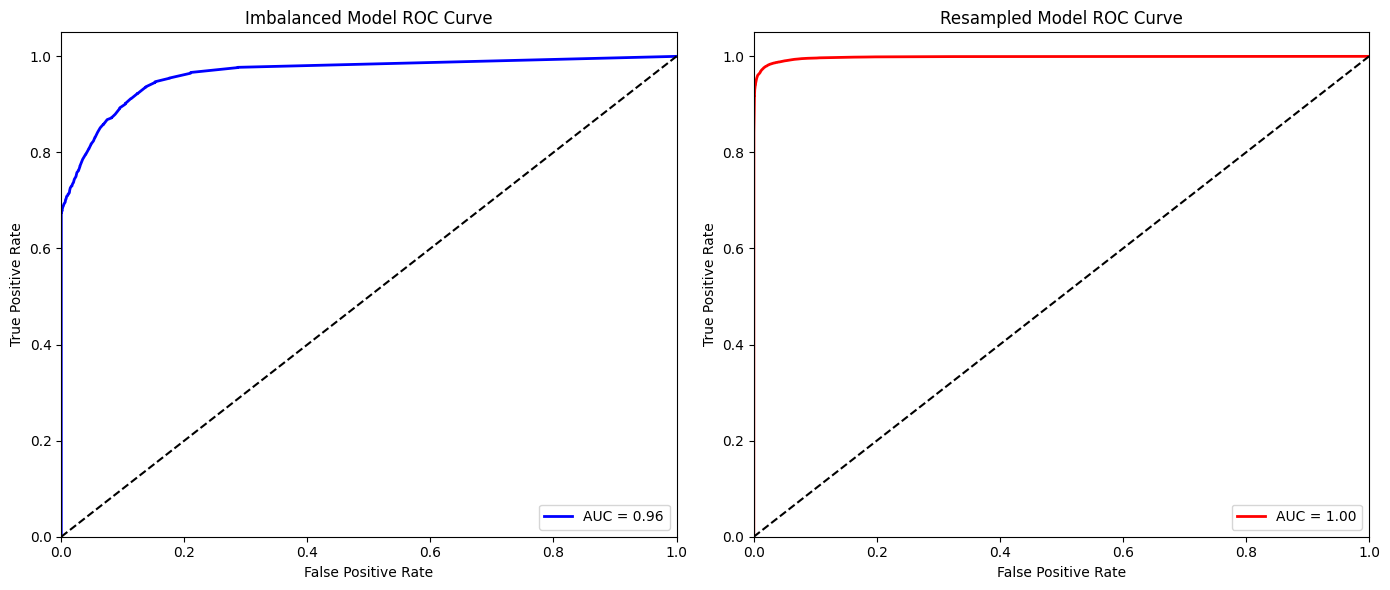

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


# Compute ROC curve and ROC area for both models
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

fpr_rs, tpr_rs, _ = roc_curve(y_test_rs, y_proba_rs)
roc_auc_rs = roc_auc_score(y_test_rs, y_proba_rs)

# Create subplots: two ROC curves side by side
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC curve for the imbalanced model
ax[0].plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
ax[0].plot([0, 1], [0, 1], color='black', linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Imbalanced Model ROC Curve')
ax[0].legend(loc="lower right")

# Plot ROC curve for the resampled model
ax[1].plot(fpr_rs, tpr_rs, color='red', lw=2, label=f'AUC = {roc_auc_rs:.2f}')
ax[1].plot([0, 1], [0, 1], color='black', linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Resampled Model ROC Curve')
ax[1].legend(loc="lower right")

# Adjust spacing between plots
plt.tight_layout()

# Show plots
plt.show()

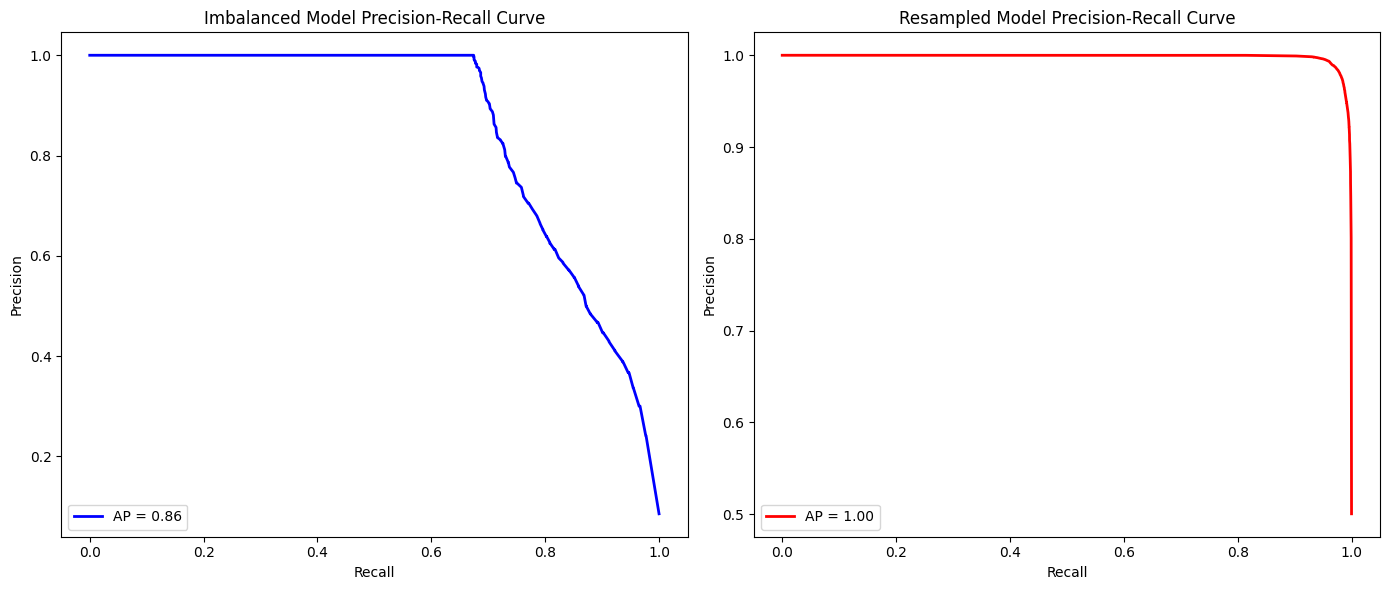

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall curve and average precision score for both models
precision, recall, _ = precision_recall_curve(y_test, y_proba)
average_precision = average_precision_score(y_test, y_proba)

precision_rs, recall_rs, _ = precision_recall_curve(y_test_rs, y_proba_rs)
average_precision_rs = average_precision_score(y_test_rs, y_proba_rs)

# Create subplots: two PR curves side by side
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot PR curve for the imbalanced model
ax[0].plot(recall, precision, color='blue', lw=2, label=f'AP = {average_precision:.2f}')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title('Imbalanced Model Precision-Recall Curve')
ax[0].legend(loc="lower left")

# Plot PR curve for the resampled model
ax[1].plot(recall_rs, precision_rs, color='red', lw=2, label=f'AP = {average_precision_rs:.2f}')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Resampled Model Precision-Recall Curve')
ax[1].legend(loc="lower left")

# Adjust spacing between plots
plt.tight_layout()

# Show plots
plt.show()



[Kaggle Code Link: PIMA Dataset](https://www.kaggle.com/code/ekrembayar/pima-indians-diabetes-classification) (Gestational Diabetes)

Packages

In [ ]:
# Base
# -----------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Models
# -----------------------------------
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# Metrics & Evaluation
# -----------------------------------
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report

# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 5.2 MB/s eta 0:00:00


In [ ]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
df = pd.read_csv(url, names=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'])

In [ ]:
print(df.isnull().sum() / df.shape[0], "\n")

missing = ["Glucose", "BMI", "BloodPressure", "SkinThickness", "Insulin"]
for i in missing:
    df[i] = np.where(df[i] == 0, np.nan, df[i])

def missing_imp_category(data, group_variable, target, method = "mean"):
    data[target] = data[target].fillna(data.groupby(group_variable)[target].transform(method))

df.isnull().sum().sort_values(ascending = False) / df.shape[0]

Pregnancies                0.00
Glucose                    0.00
BloodPressure              0.00
SkinThickness              0.00
Insulin                    0.00
BMI                        0.00
DiabetesPedigreeFunction   0.00
Age                        0.00
Outcome                    0.00
dtype: float64 



,0
Insulin,0.49
SkinThickness,0.30
BloodPressure,0.05
BMI,0.01
Glucose,0.01
Pregnancies,0.00
DiabetesPedigreeFunction,0.00
Age,0.00
Outcome,0.00


In [ ]:
# Age Category
df["AGECAT"] = pd.cut(df.Age, 5, labels = np.arange(1,6,1))

# Fill Missing
missing_imp_category(df, group_variable=["AGECAT", "Outcome"], target = "BMI", method="median")

In [ ]:
# BMI Category
df["BMI_CAT"] = np.where(df.BMI < 18.5, "UNDERWEIGHT", "NORMAL")
df["BMI_CAT"] = np.where((df.BMI >= 25) & (df.BMI < 30), "OVERRWEIGHT", df["BMI_CAT"])
df["BMI_CAT"] = np.where((df.BMI >= 30) & (df.BMI < 35), "OBESE", df["BMI_CAT"])
df["BMI_CAT"] = np.where((df.BMI >= 35), "EXTREMELY OBESE", df["BMI_CAT"])
df["ISOBESE"] = np.where(df.BMI >= 30, 1, 0)

# Fill Missing
missing_imp_category(df, group_variable=["BMI_CAT", "Outcome"], target = "SkinThickness", method="median")

# Fill Missing
df["Glucose"] = df.Glucose.fillna(df.Glucose.median())

In [ ]:
# Fill Missing
missing_imp_category(df, group_variable=["AGECAT", "Outcome"], target = "BloodPressure", method="median")

# DIASTOLIC
df["DIASTOLIC"] = np.where(df.BloodPressure < 80, "Normal", "Hypertension Stg1")
df["DIASTOLIC"] = np.where((df.BloodPressure >= 90) & (df.BloodPressure < 120), "Hypertension Stg2", df["DIASTOLIC"])
df["DIASTOLIC"] = np.where((df.BloodPressure > 120), "Hypertensive Crisis", df["DIASTOLIC"])


# Fill Missing
missing_imp_category(df, group_variable=["AGECAT", "Outcome"], target = "Insulin", method="median")
missing_imp_category(df, group_variable=["Outcome"], target = "Insulin", method="median")

In [ ]:
# Pregnancies
df["CHILD"] = np.where(df.Pregnancies > 0, 1, 0)
df["PregnanciesCAT"] = np.where(df.Pregnancies == 0, "No", "1-3")
df["PregnanciesCAT"] = np.where((df.Pregnancies > 3) & (df.Pregnancies < 10), "4-9", df["PregnanciesCAT"])
df["PregnanciesCAT"] = np.where((df.Pregnancies > 10), "10+", df["PregnanciesCAT"])

# Hypoglycemia
df["Hypoglycemia"] = np.where(df.Glucose < 75, 1,0)

# Risk Score
df["IDAgeRiskScore"] = np.where(df.Age < 35, 0 , 20)
df["IDAgeRiskScore"] = np.where(df.Age > 49, 30 , df["IDAgeRiskScore"])
df["IDBMIRiskScore"] = np.where(df.BMI < 30 , 0, 10)
df["IDBMIRiskScore"] = np.where((df.BMI >= 45) & (df.BMI < 55) , 20, df["IDBMIRiskScore"])
df["IDBMIRiskScore"] = np.where((df.BMI >= 55), 30, df["IDBMIRiskScore"])

# Pregnancies
df["CHILD"] = np.where(df.Pregnancies > 0, 1, 0)
df["PregnanciesCAT"] = np.where(df.Pregnancies == 0, "No", "1-3")
df["PregnanciesCAT"] = np.where((df.Pregnancies > 3) & (df.Pregnancies < 10), "4-9", df["PregnanciesCAT"])
df["PregnanciesCAT"] = np.where((df.Pregnancies > 10), "10+", df["PregnanciesCAT"])

# Hypoglycemia
df["Hypoglycemia"] = np.where(df.Glucose < 75, 1,0)

# Risk Score
df["IDAgeRiskScore"] = np.where(df.Age < 35, 0 , 20)
df["IDAgeRiskScore"] = np.where(df.Age > 49, 30 , df["IDAgeRiskScore"])
df["IDBMIRiskScore"] = np.where(df.BMI < 30 , 0, 10)
df["IDBMIRiskScore"] = np.where((df.BMI >= 45) & (df.BMI < 55) , 20, df["IDBMIRiskScore"])
df["IDBMIRiskScore"] = np.where((df.BMI >= 55), 30, df["IDBMIRiskScore"])


## Skin Thickness, BMI and Age
df["ST_BMI"] = df["SkinThickness"] / df["BMI"]
df["ST_BMI_Age"] = (df.BMI * df.SkinThickness ) / df.Age

df["New_SkinThickness"] = df["SkinThickness"] * 4

df.loc[(df['Age'] >= 21 ) & (df['Age'] <= 29) & (df["New_SkinThickness"] < 34), 'Body_Fat'] = "Underfat"
df.loc[(df['Age'] >= 30 ) & (df['Age'] <= 39) & (df["New_SkinThickness"] < 29), 'Body_Fat'] = "Underfat"
df.loc[(df['Age'] >= 40 ) & (df['Age'] <= 49) & (df["New_SkinThickness"] < 23), 'Body_Fat'] = "Underfat"
df.loc[(df['Age'] >= 50 ) & (df["New_SkinThickness"] < 20), 'Body_Fat'] = "Underfat"

df.loc[(df['Age'] >= 21 ) & (df['Age'] <= 29) & (df["New_SkinThickness"] >= 34) & (df["New_SkinThickness"] <= 79), 'Body_Fat'] = "Healthy"
df.loc[(df['Age'] >= 30 ) & (df['Age'] <= 39) & (df["New_SkinThickness"] >= 29) & (df["New_SkinThickness"] <= 73), 'Body_Fat'] = "Healthy"
df.loc[(df['Age'] >= 40 ) & (df['Age'] <= 49) & (df["New_SkinThickness"] >= 23) & (df["New_SkinThickness"] <= 59), 'Body_Fat'] = "Healthy"
df.loc[(df['Age'] >= 50 ) & (df["New_SkinThickness"] >= 20) & (df["New_SkinThickness"] <= 49), 'Body_Fat'] = "Healthy"

df.loc[(df['Age'] >= 21 ) & (df['Age'] <= 29) &( df["New_SkinThickness"] > 79) & (df["New_SkinThickness"] <= 120), 'Body_Fat'] = "OverFat"
df.loc[(df['Age'] >= 30) & (df['Age'] <= 39) & (df["New_SkinThickness"] > 73) & (df["New_SkinThickness"] <= 115), 'Body_Fat'] = "OverFat"
df.loc[(df['Age'] >= 40 ) & (df['Age'] <= 49) & (df["New_SkinThickness"] > 59) & (df["New_SkinThickness"] <= 95), 'Body_Fat'] = "OverFat"
df.loc[(df['Age'] >= 50 ) & (df["New_SkinThickness"] > 49) & (df["New_SkinThickness"] <= 77), 'Body_Fat'] = "OverFat"

df.loc[(df['Age'] >= 21 ) & (df['Age'] <= 29) & (df["New_SkinThickness"] > 120), 'Body_Fat'] = "Obese"
df.loc[(df['Age'] >= 30 ) & (df['Age'] <= 39) & (df["New_SkinThickness"] > 115) , 'Body_Fat'] = "Obese"
df.loc[(df['Age'] >= 40 ) & (df['Age'] <= 49) & (df["New_SkinThickness"] > 95) , 'Body_Fat'] = "Obese"
df.loc[(df['Age'] >= 50 )  & (df["New_SkinThickness"] > 77) , 'Body_Fat'] = "Obese"

df = df.drop(["New_SkinThickness"], axis=1)

## Glucose
df.loc[(df["Glucose"] < 140), "GlucoseCAT"] = "No_Risk"
df.loc[(df["Glucose"] >= 140), "GlucoseCAT"] = "Prediabetes"

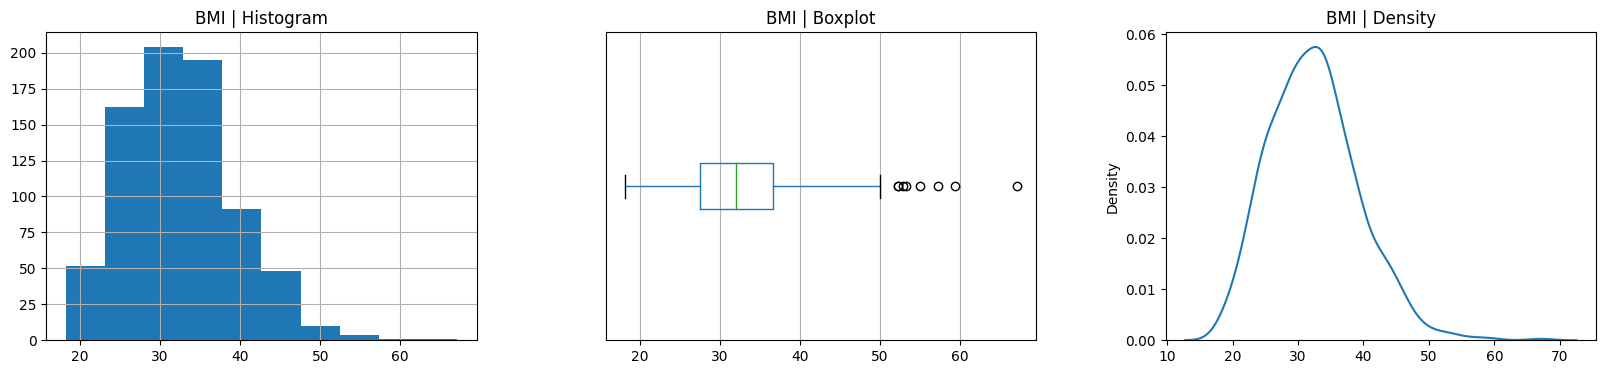

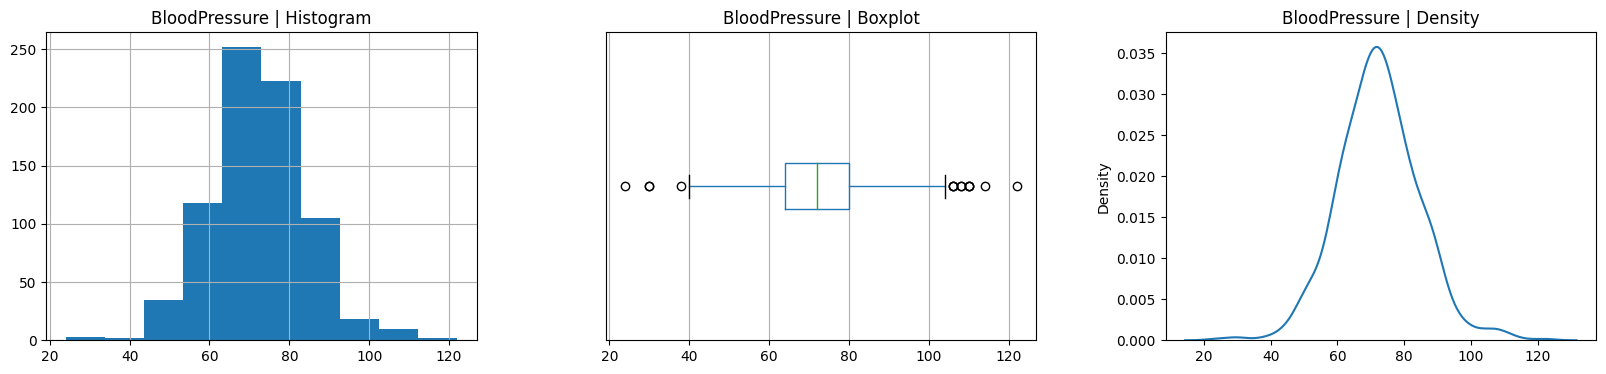

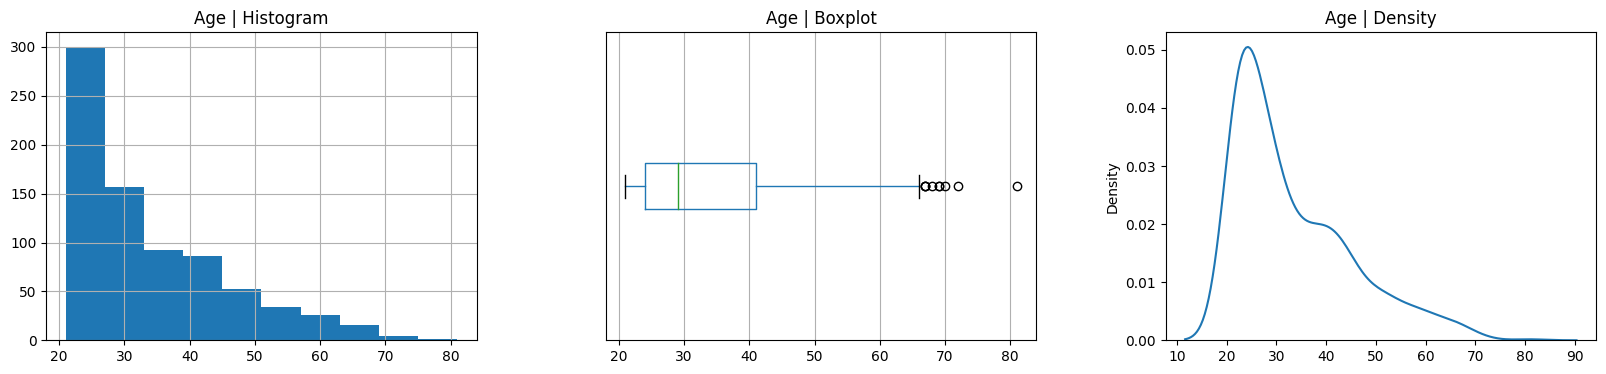

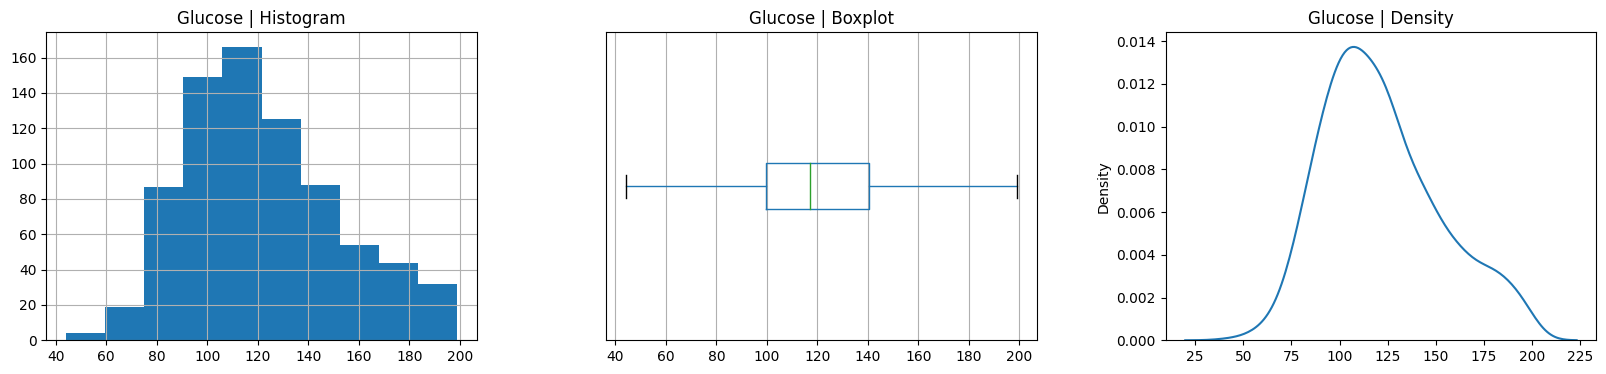

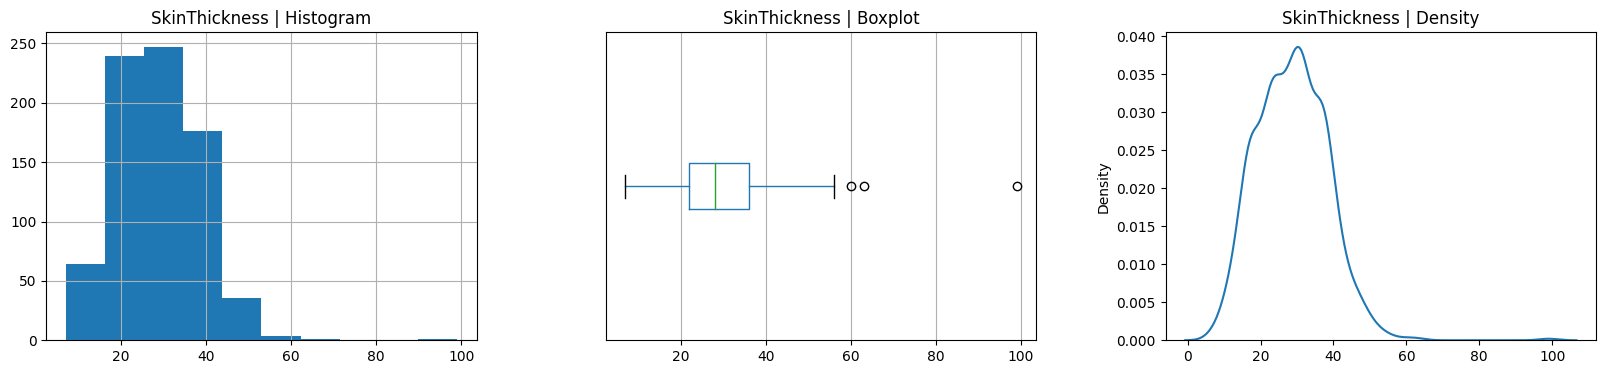

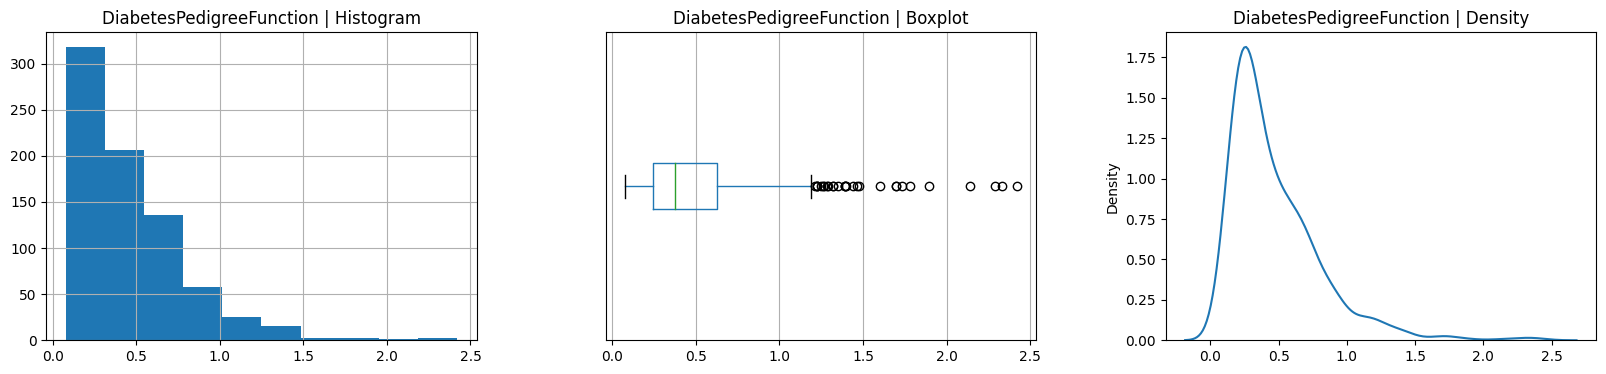

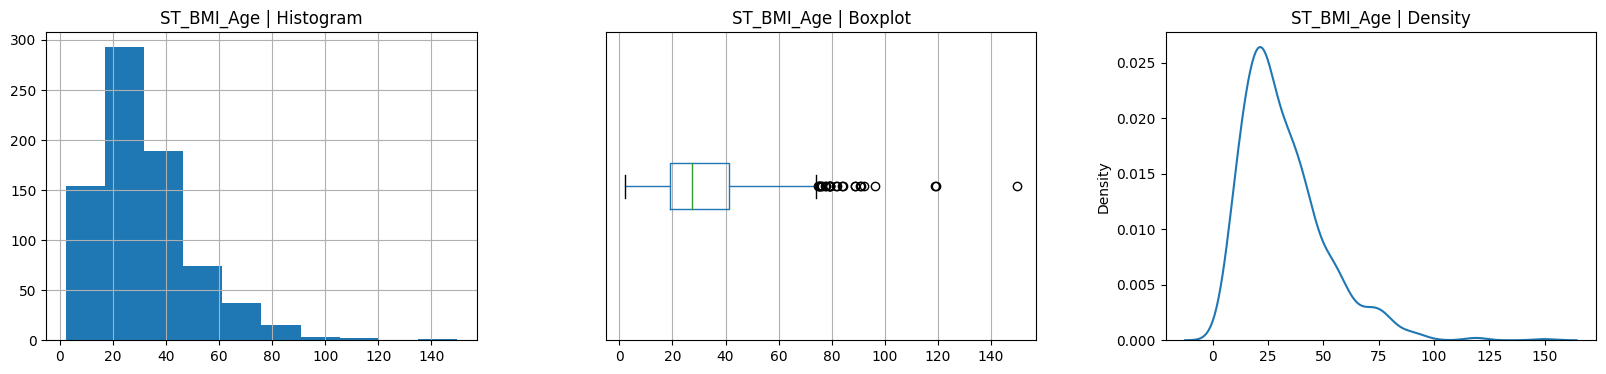

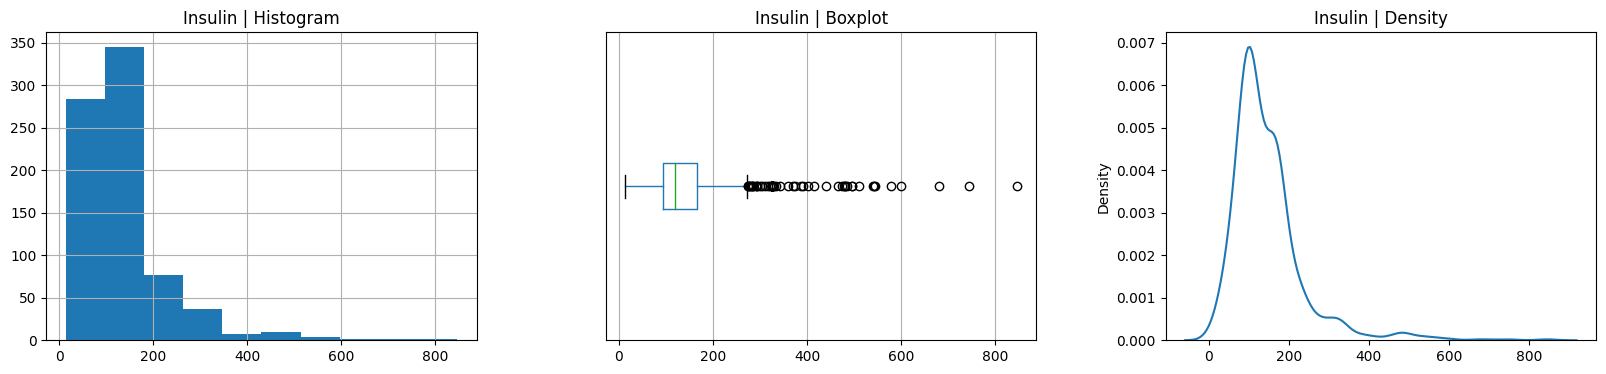

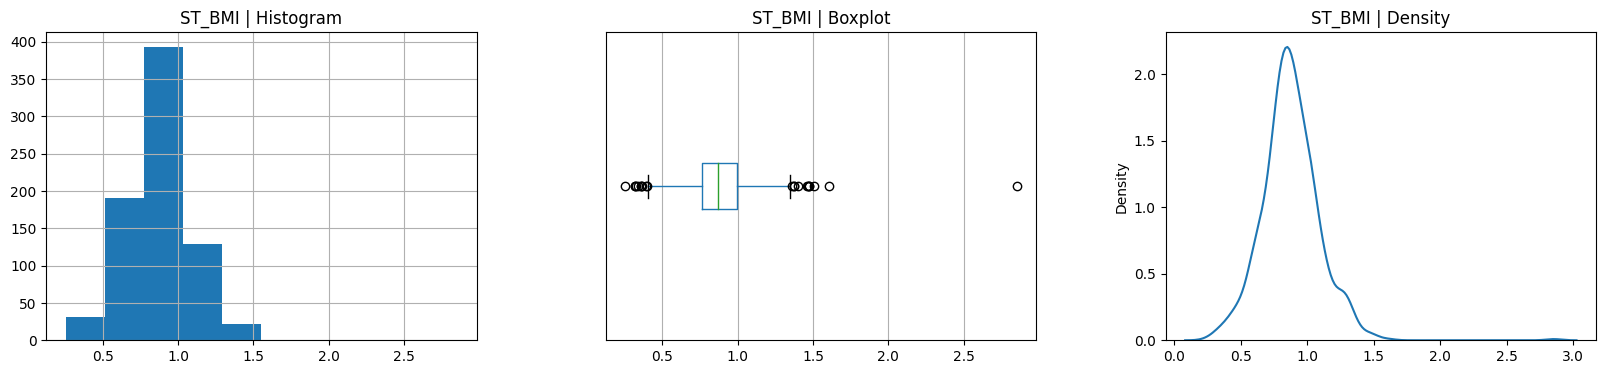

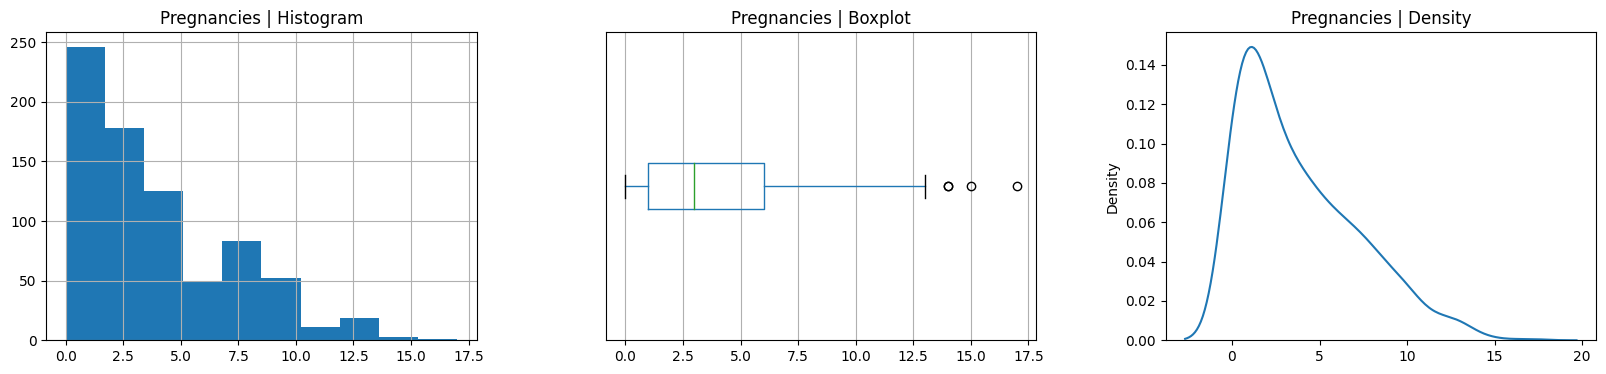

In [ ]:

def num_plot(data, cat_length = 16, remove = ["Id"], hist_bins = 12, figsize = (20,4)):

    num_cols = [col for col in data.columns if data[col].dtypes != "O"
                and len(data[col].unique()) >= cat_length]

    if len(remove) > 0:
        num_cols = list(set(num_cols).difference(remove))

    for i in num_cols:
        fig, axes = plt.subplots(1, 3, figsize = figsize)
        data.hist(str(i), bins = hist_bins, ax=axes[0])
        data.boxplot(str(i),  ax=axes[1], vert=False);
        try:
            sns.kdeplot(np.array(data[str(i)]))
        except: ValueError

        axes[1].set_yticklabels([])
        axes[1].set_yticks([])
        axes[0].set_title(i + " | Histogram")
        axes[1].set_title(i + " | Boxplot")
        axes[2].set_title(i + " | Density")
        plt.show()


num_plot(df, cat_length = 16, hist_bins = 10, figsize = (20,4))

In [ ]:
def cat_eda(data, cat_length, target = "Outcome"):
    dataframe = data.copy()

    #if len(ordinal_variable) > 0:
    #    dataframe.drop(ordinal_variable, axis = 1, inplace = True)

    more_cat_cols = [col for col in dataframe.columns if len(dataframe[col].unique()) < cat_length]

    for i in more_cat_cols:
        print(i, ":", len(dataframe[i].value_counts()), "Unique Category -", str(dataframe[i].dtype))
        print(pd.DataFrame({"COUNT": dataframe[i].value_counts(),
                            "RATIO": dataframe[i].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(i)[target].mean(),
                            "TARGET_COUNT": dataframe.groupby(i)[target].count(),
                            "TARGET_STD": dataframe.groupby(i)[target].std()}), end="\n\n\n")

    print("# DTYPES -----------------------------")
    print("Object Variables:",dataframe[more_cat_cols].select_dtypes("object").columns.tolist(), "\n")
    print("Integer Variables:",dataframe[more_cat_cols].select_dtypes("integer").columns.tolist(), "\n")
    print("Float Variables:",dataframe[more_cat_cols].select_dtypes("float").columns.tolist(), "\n")

cat_eda(df, cat_length=10)

Outcome : 2 Unique Category - int64
         COUNT  RATIO  TARGET_MEAN  TARGET_COUNT  TARGET_STD
Outcome                                                     
0          500   0.65         0.00           500        0.00
1          268   0.35         1.00           268        0.00


AGECAT : 5 Unique Category - category
        COUNT  RATIO  TARGET_MEAN  TARGET_COUNT  TARGET_STD
AGECAT                                                     
1         474   0.62         0.26           474        0.44
2         176   0.23         0.50           176        0.50
3          76   0.10         0.58            76        0.50
4          39   0.05         0.33            39        0.48
5           3   0.00         0.33             3        0.58


BMI_CAT : 5 Unique Category - object
                 COUNT  RATIO  TARGET_MEAN  TARGET_COUNT  TARGET_STD
BMI_CAT                                                             
EXTREMELY OBESE    248   0.32         0.48           248        0.50
NORMAL        

In [ ]:
# Transform Object
df["AGECAT"] = df["AGECAT"].astype(object)

cat_cols = [col for col in df.columns if df[col].dtypes == 'O']

def one_hot_encoder(dataframe, categorical_cols, nan_as_category=True):
    original_columns = list(dataframe.columns)
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, dummy_na=nan_as_category, drop_first=True)
    new_columns = [c for c in dataframe.columns if c not in original_columns]
    return dataframe, new_columns


df, new_cols_ohe = one_hot_encoder(df, cat_cols, nan_as_category=False)

# Algorithm Comparison
-----------------------------------------
LR: 0.770465 (0.060529)
NBAYES: 0.589476 (0.056920)
KNN: 0.835695 (0.051537)
CART: 0.843813 (0.038682)
BAGGING: 0.871497 (0.030484)
RF: 0.858593 (0.051690)
SVM: 0.656795 (0.064014)
ADAB: 0.842200 (0.032467)
GBM: 0.868297 (0.048587)
XGB: 0.871576 (0.046003)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 189, number of negative: 363
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1041
[LightGBM] [Info] Number of data points in the train set: 552, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342391 -> initscore=-0.652656
[LightGBM] [Info] Start training from score -0.652656
[LightGBM] [Warning] No further splits with po

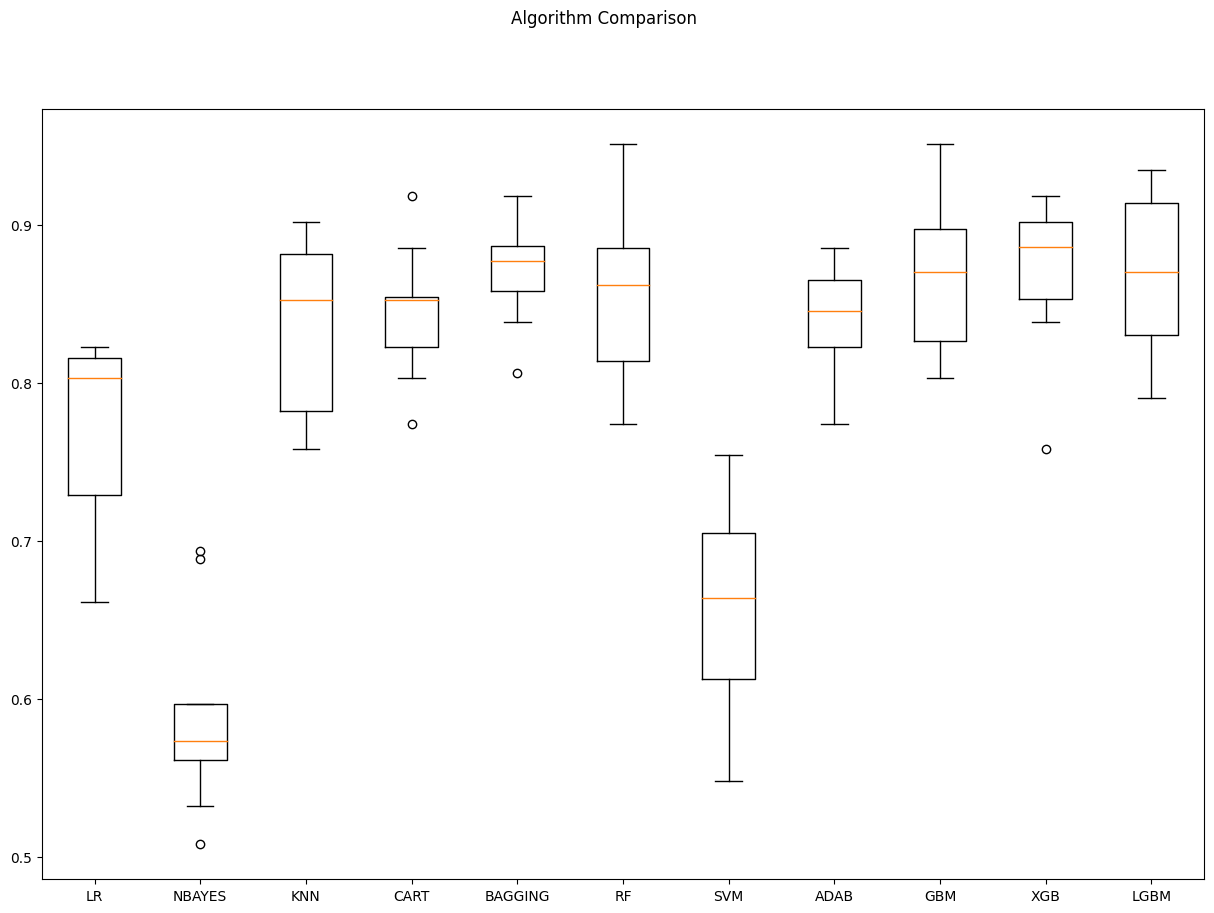

In [ ]:
# All Models & Train Validation Scores
models = [('LR', LogisticRegression()),
          ("NBAYES", GaussianNB()),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ("BAGGING", BaggingClassifier()),
          ('RF', RandomForestClassifier()),
          ('SVM', SVC(gamma='auto')),
          ("ADAB",AdaBoostClassifier()),
          ('GBM', GradientBoostingClassifier()),
          ("XGB", XGBClassifier()),
          ("LGBM", LGBMClassifier())]


y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=46)

# evaluate each model in turn
results = []
names = []

print("# Algorithm Comparison")
print("-----------------------------------------")
for name, model in models:
    kfold = KFold(n_splits=10, random_state=123456, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
print("\n")

# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Diabetes Health Indicators (Prediabetes?) [Kaggle Code Link](https://www.kaggle.com/code/devraai/diabetes-health-indicators-analysis-and-prediction)

In [ ]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Load Datasets

In [ ]:
# Load the datasets
df_012 = pd.read_csv('/content/diabetes_012_health_indicators_BRFSS2015.csv')
df_binary = pd.read_csv('/content/diabetes_binary_health_indicators_BRFSS2015.csv')
df_5050 = pd.read_csv('/content/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

# Display the first few rows of each dataset
df_012.head(), df_binary.head(), df_5050.head()

(   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
 0           0.0     1.0       1.0        1.0  40.0     1.0     0.0   
 1           0.0     0.0       0.0        0.0  25.0     1.0     0.0   
 2           0.0     1.0       1.0        1.0  28.0     0.0     0.0   
 3           0.0     1.0       0.0        1.0  27.0     0.0     0.0   
 4           0.0     1.0       1.0        1.0  24.0     0.0     0.0   
 
    HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
 0                   0.0           0.0     0.0  ...            1.0   
 1                   0.0           1.0     0.0  ...            0.0   
 2                   0.0           0.0     1.0  ...            1.0   
 3                   0.0           1.0     1.0  ...            1.0   
 4                   0.0           1.0     1.0  ...            1.0   
 
    NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
 0          0.0      5.0      18.0      15.0       1.0  0.0   9.0     

Data Overview

In [ ]:
# Display basic information and summary statistics
df_012.info(), df_012.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

(None,
         Diabetes_012         HighBP       HighChol      CholCheck  \
 count  253680.000000  253680.000000  253680.000000  253680.000000   
 mean        0.296921       0.429001       0.424121       0.962670   
 std         0.698160       0.494934       0.494210       0.189571   
 min         0.000000       0.000000       0.000000       0.000000   
 25%         0.000000       0.000000       0.000000       1.000000   
 50%         0.000000       0.000000       0.000000       1.000000   
 75%         0.000000       1.000000       1.000000       1.000000   
 max         2.000000       1.000000       1.000000       1.000000   
 
                  BMI         Smoker         Stroke  HeartDiseaseorAttack  \
 count  253680.000000  253680.000000  253680.000000         253680.000000   
 mean       28.382364       0.443169       0.040571              0.094186   
 std         6.608694       0.496761       0.197294              0.292087   
 min        12.000000       0.000000       0.000000  

In [ ]:
df_5050.info(), df_5050.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

(None,
        Diabetes_binary        HighBP      HighChol     CholCheck  \
 count     70692.000000  70692.000000  70692.000000  70692.000000   
 mean          0.500000      0.563458      0.525703      0.975259   
 std           0.500004      0.495960      0.499342      0.155336   
 min           0.000000      0.000000      0.000000      0.000000   
 25%           0.000000      0.000000      0.000000      1.000000   
 50%           0.500000      1.000000      1.000000      1.000000   
 75%           1.000000      1.000000      1.000000      1.000000   
 max           1.000000      1.000000      1.000000      1.000000   
 
                 BMI        Smoker        Stroke  HeartDiseaseorAttack  \
 count  70692.000000  70692.000000  70692.000000          70692.000000   
 mean      29.856985      0.475273      0.062171              0.147810   
 std        7.113954      0.499392      0.241468              0.354914   
 min       12.000000      0.000000      0.000000              0.000000   


In [ ]:
df_binary.info(), df_binary.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

(None,
        Diabetes_binary         HighBP       HighChol      CholCheck  \
 count    253680.000000  253680.000000  253680.000000  253680.000000   
 mean          0.139333       0.429001       0.424121       0.962670   
 std           0.346294       0.494934       0.494210       0.189571   
 min           0.000000       0.000000       0.000000       0.000000   
 25%           0.000000       0.000000       0.000000       1.000000   
 50%           0.000000       0.000000       0.000000       1.000000   
 75%           0.000000       1.000000       1.000000       1.000000   
 max           1.000000       1.000000       1.000000       1.000000   
 
                  BMI         Smoker         Stroke  HeartDiseaseorAttack  \
 count  253680.000000  253680.000000  253680.000000         253680.000000   
 mean       28.382364       0.443169       0.040571              0.094186   
 std         6.608694       0.496761       0.197294              0.292087   
 min        12.000000       0.00000

Correlation Analysis

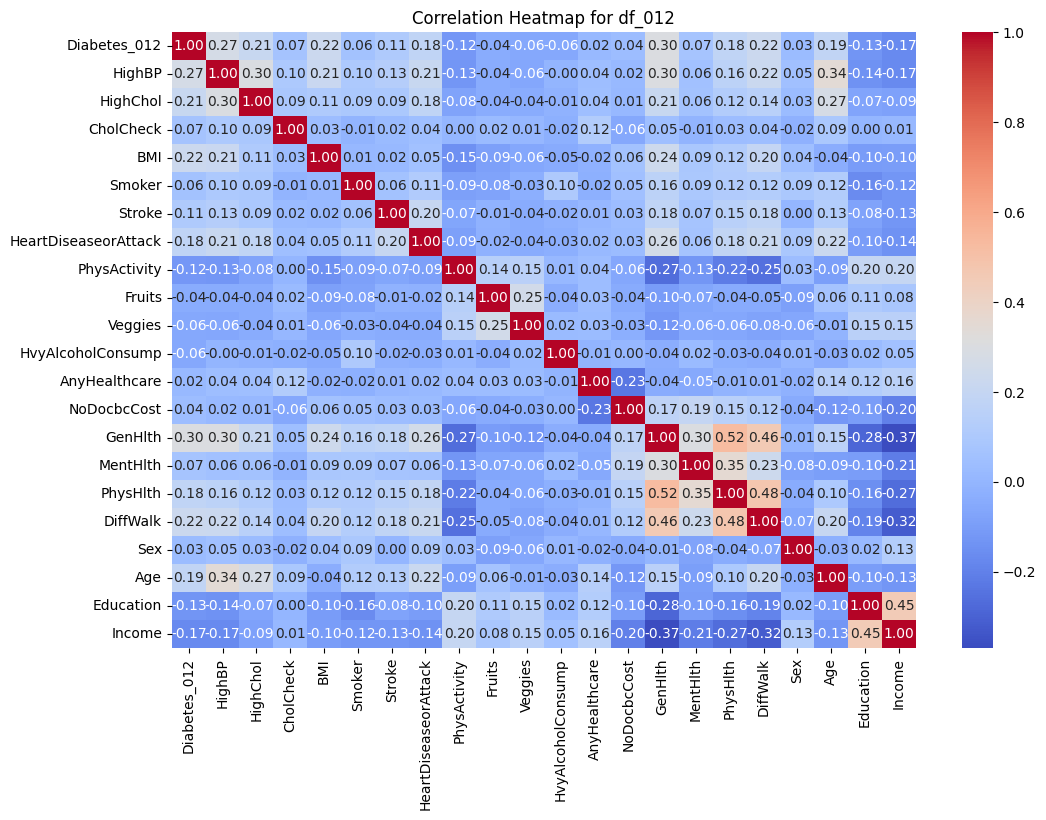

In [ ]:
# Correlation heatmap for df_012
numeric_df_012 = df_012.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df_012.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap for df_012')
plt.show()

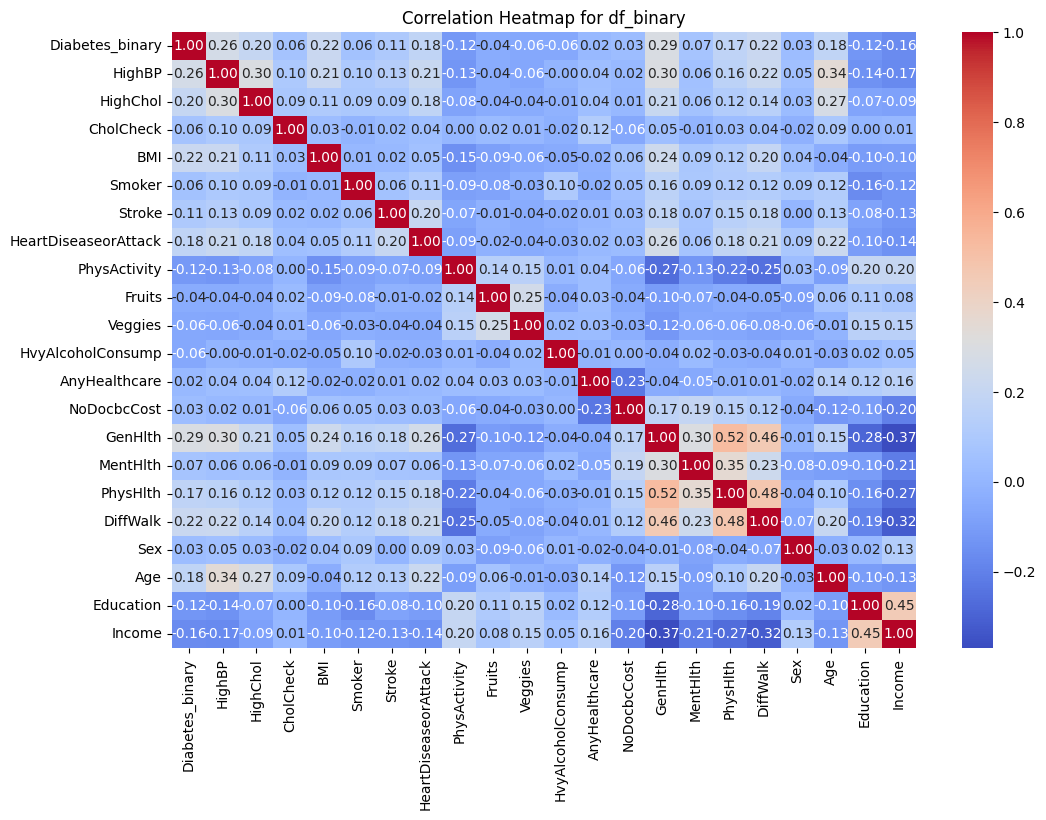

In [ ]:
# Correlation heatmap for df_binary
numeric_df_binary = df_binary.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df_binary.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap for df_binary')
plt.show()

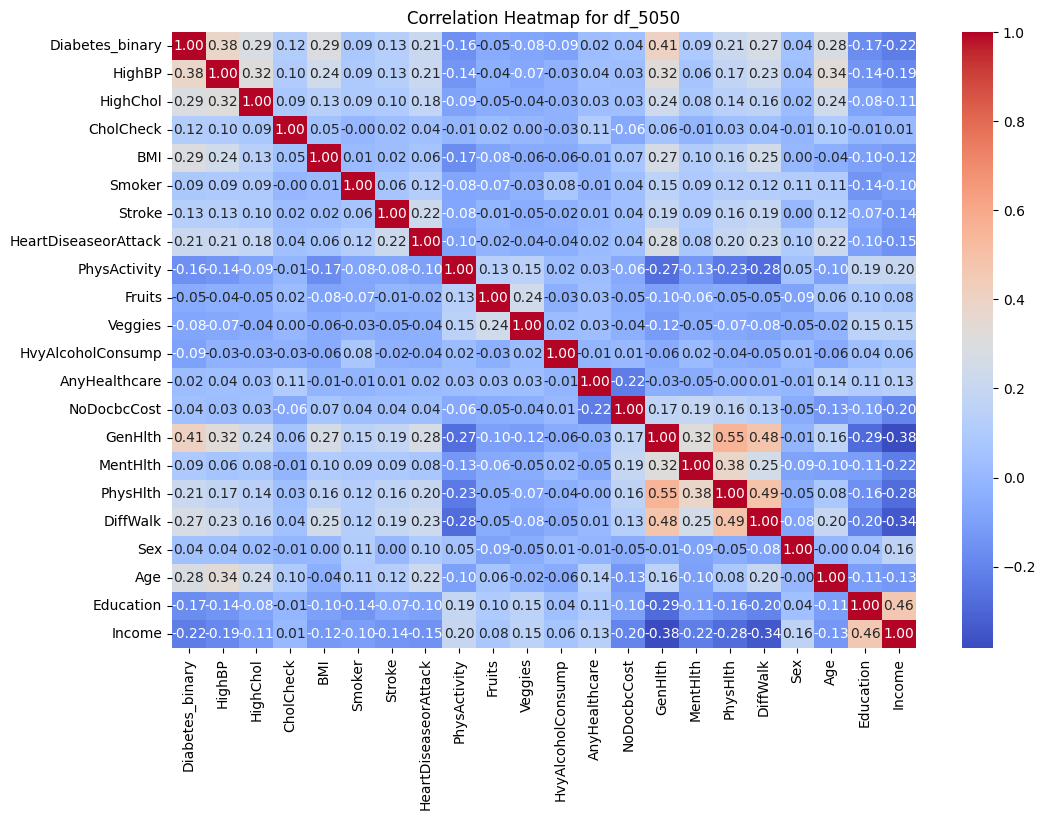

In [ ]:
# Correlation heatmap for df_5050
numeric_df_5050 = df_5050.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df_5050.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap for df_5050')
plt.show()

In [ ]:
# Prepare the data for modeling
X = df_binary.drop('Diabetes_binary', axis=1)
y = df_binary['Diabetes_binary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(accuracy)
print(conf_matrix)
print(class_report)

0.8601781772311574
[[63634  1971]
 [ 8670  1829]]
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     65605
         1.0       0.48      0.17      0.26     10499

    accuracy                           0.86     76104
   macro avg       0.68      0.57      0.59     76104
weighted avg       0.83      0.86      0.83     76104



Using my own custom dataset and running the models again...

Creating the Custom Dataset

In [3]:
import pandas as pd

pima_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
# Import the datasets
diabetes_prediction_df = pd.read_csv('/content/diabetes_prediction_dataset.csv')
health_indicators_df = pd.read_csv('/content/diabetes_binary_health_indicators_BRFSS2015.csv')
binary_5050_df = pd.read_csv('/content/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
diabetes_012_df = pd.read_csv('/content/diabetes_012_health_indicators_BRFSS2015.csv')
gestational_diabetes_df = pd.read_csv(pima_url, names=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'])

gestational_diabetes_df.to_csv('gestational_diabetes_dataset.csv', index=False)



# Align columns across datasets by renaming
diabetes_prediction_df.rename(columns={'age': 'Age', 'bmi': 'BMI', 'blood_glucose_level': 'Glucose', 'heart_disease': 'HeartDiseaseorAttack', 'hypertension': 'HighBP', 'diabetes': 'Diabetes_binary'}, inplace=True)
gestational_diabetes_df.rename(columns={'Outcome': 'Diabetes_binary'}, inplace=True)

# Add 'Pregnancies', 'BloodPressure', and 'SkinThickness' to the other datasets (fill with pd.NA)
diabetes_prediction_df['Pregnancies'] = pd.NA
diabetes_prediction_df['BloodPressure'] = pd.NA
diabetes_prediction_df['SkinThickness'] = pd.NA

health_indicators_df['Pregnancies'] = pd.NA
health_indicators_df['BloodPressure'] = pd.NA
health_indicators_df['SkinThickness'] = pd.NA

binary_5050_df['Pregnancies'] = pd.NA
binary_5050_df['BloodPressure'] = pd.NA
binary_5050_df['SkinThickness'] = pd.NA

diabetes_012_df['Pregnancies'] = pd.NA
diabetes_012_df['BloodPressure'] = pd.NA
diabetes_012_df['SkinThickness'] = pd.NA

# Add diabetes type labels:
# Label 0: No diabetes
# Label 1: Prediabetes
# Label 2: Type-2 diabetes
# Label 3: Gestational diabetes

# For the datasets with Diabetes_binary
diabetes_prediction_df['diabetes_type'] = diabetes_prediction_df['Diabetes_binary'].apply(lambda x: 2 if x == 1 else 0)
health_indicators_df['diabetes_type'] = health_indicators_df['Diabetes_binary'].apply(lambda x: 2 if x == 1 else 0)
binary_5050_df['diabetes_type'] = binary_5050_df['Diabetes_binary'].apply(lambda x: 2 if x == 1 else 0)

# For the diabetes_012 dataset (prediabetes and type-2 diabetes)
diabetes_012_df['diabetes_type'] = diabetes_012_df['Diabetes_012'].apply(lambda x: 1 if x == 1 else (2 if x == 2 else 0))

# For the gestational diabetes dataset (gestational diabetes)
gestational_diabetes_df['diabetes_type'] = gestational_diabetes_df['Diabetes_binary'].apply(lambda x: 3 if x == 1 else 0)

# Select relevant columns for merging, including 'diabetes_type'
diabetes_prediction_selected = diabetes_prediction_df[['Age', 'BMI', 'Glucose', 'HeartDiseaseorAttack', 'HighBP', 'Pregnancies', 'BloodPressure', 'SkinThickness', 'diabetes_type']]
health_indicators_selected = health_indicators_df[['Age', 'BMI', 'HighBP', 'HeartDiseaseorAttack', 'Pregnancies', 'BloodPressure', 'SkinThickness', 'diabetes_type']]
binary_5050_selected = binary_5050_df[['Age', 'BMI', 'HighBP', 'HeartDiseaseorAttack', 'Pregnancies', 'BloodPressure', 'SkinThickness', 'diabetes_type']]
diabetes_012_selected = diabetes_012_df[['Age', 'BMI', 'HighBP', 'HeartDiseaseorAttack', 'Pregnancies', 'BloodPressure', 'SkinThickness', 'diabetes_type']]
gestational_diabetes_selected = gestational_diabetes_df[['Age', 'BMI', 'Glucose', 'Insulin', 'Pregnancies', 'BloodPressure', 'SkinThickness', 'diabetes_type']]

# Combine the datasets using pd.concat
combined_df = pd.concat([diabetes_prediction_selected, health_indicators_selected, binary_5050_selected, diabetes_012_selected, gestational_diabetes_selected], ignore_index=True)

# Handle missing values
combined_df.fillna(combined_df.mean(), inplace=True)

# Display the first few rows of the combined dataset
print(combined_df.head())

combined_df.to_csv('combined_diabetes_dataset.csv', index=False)




    Age    BMI  Glucose  HeartDiseaseorAttack  HighBP  Pregnancies  \
0  80.0  25.19    140.0                   1.0     0.0     3.845052   
1  54.0  27.32     80.0                   0.0     0.0     3.845052   
2  28.0  27.32    158.0                   0.0     0.0     3.845052   
3  36.0  23.45    155.0                   0.0     0.0     3.845052   
4  76.0  20.14    155.0                   1.0     1.0     3.845052   

   BloodPressure  SkinThickness  diabetes_type    Insulin  
0      69.105469      20.536458              0  79.799479  
1      69.105469      20.536458              0  79.799479  
2      69.105469      20.536458              0  79.799479  
3      69.105469      20.536458              0  79.799479  
4      69.105469      20.536458              0  79.799479  


Train the Model

In [ ]:
# Proceed to train the model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Prepare features (X) and labels (y)
X = combined_df.drop(columns=['diabetes_type'])
y = combined_df['diabetes_type']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91    111791
           1       0.00      0.00      0.00       897
           2       0.59      0.18      0.28     23020
           3       0.68      0.61      0.64        56

    accuracy                           0.83    135764
   macro avg       0.53      0.44      0.46    135764
weighted avg       0.80      0.83      0.79    135764



Balance the Classes

In [ ]:
# Use a fraction of the dataset for faster training
sample_df = combined_df.sample(frac=0.1, random_state=42)  # 10% of the data
X_sample = sample_df.drop(columns=['diabetes_type'])
y_sample = sample_df['diabetes_type']

# Split and train on the smaller dataset
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample minority classes after sampling the data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Retrain the RandomForest model on the balanced data
rf_model.fit(X_resampled, y_resampled)

# Make predictions and evaluate again
y_pred_resampled = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_resampled))


              precision    recall  f1-score   support

           0       0.93      0.71      0.80     11187
           1       0.00      0.03      0.01        75
           2       0.35      0.68      0.46      2310
           3       0.75      0.60      0.67         5

    accuracy                           0.70     13577
   macro avg       0.51      0.50      0.48     13577
weighted avg       0.82      0.70      0.74     13577



Trying XGBoost with Combined Dataset

In [5]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Prepare features (X) and labels (y)
X = combined_df.drop(columns=['diabetes_type'])
y = combined_df['diabetes_type']

# Feature Engineering: Adding an interaction between Glucose and BMI
combined_df['Glucose_BMI'] = combined_df['Glucose'] * combined_df['BMI']

# Use the same sampling method
sample_df = combined_df.sample(frac=0.2, random_state=42)
X_sample = sample_df.drop(columns=['diabetes_type'])
y_sample = sample_df['diabetes_type']

# Split and train on the smaller dataset
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Set up XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_resampled, y_resampled)

# Best model after tuning
best_xgb_model = grid_search.best_estimator_

# Make predictions and evaluate
y_pred_xgb = best_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

# Print best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
              precision    recall  f1-score   support

           0       0.93      0.67      0.78     22339
           1       0.01      0.11      0.01       156
           2       0.35      0.65      0.46      4648
           3       0.38      0.80      0.52        10

    accuracy                           0.67     27153
   macro avg       0.42      0.56      0.44     27153
weighted avg       0.83      0.67      0.72     27153

Best Parameters: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300}


Adding More Class 1 Samples from Different Dataset

In [6]:

new_dataset = pd.read_excel("/content/Early_stage_diabetes_risk_prediction_dataset.xlsx")
# Step 1: Map the 'Class' column to match the combined dataset's classification
# Assuming 'Positive' corresponds to Class 1 (Prediabetes) and 'Negative' to Class 0 (No diabetes)
new_dataset['diabetes_type'] = new_dataset['Class'].apply(lambda x: 1 if x == 'Positive' else 0)

# Step 2: Select relevant columns
# The new dataset does not have 'BMI', 'Glucose', or other numeric values, so we will align it based on available features.
# Adding placeholder NaN columns for missing features
new_dataset['BMI'] = pd.NA
new_dataset['Glucose'] = pd.NA
new_dataset['HeartDiseaseorAttack'] = pd.NA
new_dataset['HighBP'] = pd.NA
new_dataset['Pregnancies'] = pd.NA
new_dataset['BloodPressure'] = pd.NA
new_dataset['SkinThickness'] = pd.NA

# Select columns to align with the combined dataset
new_dataset_selected = new_dataset[['Age', 'BMI', 'Glucose', 'HeartDiseaseorAttack', 'HighBP', 'Pregnancies', 'BloodPressure', 'SkinThickness', 'diabetes_type']]

# Step 3: Combine the new dataset with the existing combined dataset
combined_df_updated = pd.concat([combined_df, new_dataset_selected], ignore_index=True)

# Display the updated combined dataset
combined_df_updated.head()


<ipython-input-6-12445ec63dc0>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df_updated = pd.concat([combined_df, new_dataset_selected], ignore_index=True)


,Age,BMI,Glucose,HeartDiseaseorAttack,HighBP,Pregnancies,BloodPressure,SkinThickness,diabetes_type,Insulin,Glucose_BMI
0,80.0,25.19,140.0,1.0,0.0,3.845052,69.105469,20.536458,0,79.799479,3526.60
1,54.0,27.32,80.0,0.0,0.0,3.845052,69.105469,20.536458,0,79.799479,2185.60
2,28.0,27.32,158.0,0.0,0.0,3.845052,69.105469,20.536458,0,79.799479,4316.56
3,36.0,23.45,155.0,0.0,0.0,3.845052,69.105469,20.536458,0,79.799479,3634.75
4,76.0,20.14,155.0,1.0,1.0,3.845052,69.105469,20.536458,0,79.799479,3121.70


Running XGBoost Again with Updated Dataset

In [8]:
# Prepare features (X) and labels (y)
X = combined_df_updated.drop(columns=['diabetes_type'])
y = combined_df_updated['diabetes_type']

# Use the same sampling method
sample_df = combined_df_updated.sample(frac=0.2, random_state=42)
X_sample = sample_df.drop(columns=['diabetes_type'])
y_sample = sample_df['diabetes_type']

# Split and train on the smaller dataset
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

from sklearn.impute import SimpleImputer

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_train)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_imputed, y_train)

# Set up XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_resampled, y_resampled)

# Best model after tuning
best_xgb_model = grid_search.best_estimator_

# Make predictions and evaluate
y_pred_xgb = best_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
              precision    recall  f1-score   support

           0       0.93      0.68      0.79     22235
           1       0.01      0.07      0.01       206
           2       0.35      0.67      0.46      4723
           3       0.37      1.00      0.54        10

    accuracy                           0.67     27174
   macro avg       0.42      0.60      0.45     27174
weighted avg       0.82      0.67      0.72     27174

Best Parameters: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300}


Oversample for Class 1 (Prediabetes) and Run Again

In [14]:
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import pandas as pd

# Sample 20% of the original dataset
sampled_df = combined_df_updated.sample(frac=0.2, random_state=42)

# Separate the data by class
class_0 = sampled_df[sampled_df['diabetes_type'] == 0]
class_1 = sampled_df[sampled_df['diabetes_type'] == 1]
class_2 = sampled_df[sampled_df['diabetes_type'] == 2]
class_3 = sampled_df[sampled_df['diabetes_type'] == 3]

# Apply imputation to handle NaNs before oversampling
imputer = SimpleImputer(strategy='mean')
X_class_1_imputed = imputer.fit_transform(class_1.drop(columns=['diabetes_type']))

# Step 1: Oversample Class 1
X_class_1_resampled, y_class_1_resampled = resample(
    X_class_1_imputed, class_1['diabetes_type'],
    replace=True,  # Allow resampling
    n_samples=len(class_0),  # Resample to match Class 0 size
    random_state=42
)

# Apply imputation to the other classes as well
X_resampled_0 = imputer.transform(class_0.drop(columns=['diabetes_type']))
X_resampled_2 = imputer.transform(class_2.drop(columns=['diabetes_type']))
X_resampled_3 = imputer.transform(class_3.drop(columns=['diabetes_type']))

# Combine all classes into one dataset
X_resampled = pd.DataFrame(
    pd.concat([pd.DataFrame(X_resampled_0), pd.DataFrame(X_resampled_2), pd.DataFrame(X_resampled_3), pd.DataFrame(X_class_1_resampled)], ignore_index=True)
)
y_resampled = pd.concat([class_0['diabetes_type'], class_2['diabetes_type'], class_3['diabetes_type'], pd.Series(y_class_1_resampled)], ignore_index=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train the XGBoost model again on the newly balanced dataset
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Best model after tuning
best_xgb_model = grid_search.best_estimator_

# Make predictions and evaluate
y_pred_xgb = best_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

# Print best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
              precision    recall  f1-score   support

           0       0.73      0.69      0.71     22230
           1       0.67      0.82      0.74     22349
           2       0.59      0.13      0.21      4716
           3       0.80      0.57      0.67        14

    accuracy                           0.70     49309
   macro avg       0.70      0.55      0.58     49309
weighted avg       0.69      0.70      0.67     49309

Best Parameters: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300}


Increasing Class 2 and Class 3 Samples

In [15]:
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import pandas as pd

# Sample 20% of the original dataset
sampled_df = combined_df_updated.sample(frac=0.2, random_state=42)

# Separate the data by class from the sampled dataset
class_0 = sampled_df[sampled_df['diabetes_type'] == 0]
class_1 = sampled_df[sampled_df['diabetes_type'] == 1]
class_2 = sampled_df[sampled_df['diabetes_type'] == 2]
class_3 = sampled_df[sampled_df['diabetes_type'] == 3]

# Get the target size (number of samples in Class 1)
target_size = len(class_1)

# Apply imputation to handle NaNs before oversampling
imputer = SimpleImputer(strategy='mean')

# Impute missing values for Class 1
X_class_1_imputed = imputer.fit_transform(class_1.drop(columns=['diabetes_type']))

# Step 1: Oversample Class 2 and Class 3 to match Class 1 size
X_class_2_imputed = imputer.transform(class_2.drop(columns=['diabetes_type']))
X_class_2_resampled, y_class_2_resampled = resample(
    X_class_2_imputed, class_2['diabetes_type'],
    replace=True,  # Allow resampling
    n_samples=target_size,  # Resample to match Class 1 size
    random_state=42
)

X_class_3_imputed = imputer.transform(class_3.drop(columns=['diabetes_type']))
X_class_3_resampled, y_class_3_resampled = resample(
    X_class_3_imputed, class_3['diabetes_type'],
    replace=True,  # Allow resampling
    n_samples=target_size,  # Resample to match Class 1 size
    random_state=42
)

# Step 2: Apply imputation and resample Class 0 to maintain balance
X_resampled_0 = imputer.transform(class_0.drop(columns=['diabetes_type']))

# Combine all resampled classes into one dataset
X_resampled = pd.DataFrame(
    pd.concat([pd.DataFrame(X_resampled_0), pd.DataFrame(X_class_2_resampled), pd.DataFrame(X_class_3_resampled), pd.DataFrame(X_class_1_imputed)], ignore_index=True)
)
y_resampled = pd.concat([class_0['diabetes_type'], pd.Series(y_class_2_resampled), pd.Series(y_class_3_resampled), class_1['diabetes_type']], ignore_index=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train the XGBoost model again on the newly balanced dataset
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Best model after tuning
best_xgb_model = grid_search.best_estimator_

# Make predictions and evaluate
y_pred_xgb = best_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

# Print best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     22381
           1       0.59      0.05      0.10       188
           2       1.00      0.03      0.05       179
           3       0.96      1.00      0.98       198

    accuracy                           0.98     22946
   macro avg       0.88      0.52      0.53     22946
weighted avg       0.98      0.98      0.98     22946

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
